# Guía Práctica de ML
En esta guía haremos una progresión desde los modelos más simples posibles, quizás con más errores, a los modelos de ML más complejos y utilizados. <br />
Esta progresión también tiene la intención de mostrar el recorrido del ML en profundidad y especificidad

In [528]:
# Librerías standard
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeRegressor

In [529]:
df = pd.read_csv('./house_data.csv')
df

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra,-37.79960,144.99840,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.80790,144.99340,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.80930,144.99440,Northern Metropolitan,4019.0
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,...,2.0,1.0,94.0,NaN,NaN,Yarra,-37.79690,144.99690,Northern Metropolitan,4019.0
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,...,1.0,2.0,120.0,142.0,2014.0,Yarra,-37.80720,144.99410,Northern Metropolitan,4019.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13575,Wheelers Hill,12 Strada Cr,4,h,1245000.0,S,Barry,26/08/2017,16.7,3150.0,...,2.0,2.0,652.0,NaN,1981.0,NaN,-37.90562,145.16761,South-Eastern Metropolitan,7392.0
13576,Williamstown,77 Merrett Dr,3,h,1031000.0,SP,Williams,26/08/2017,6.8,3016.0,...,2.0,2.0,333.0,133.0,1995.0,NaN,-37.85927,144.87904,Western Metropolitan,6380.0
13577,Williamstown,83 Power St,3,h,1170000.0,S,Raine,26/08/2017,6.8,3016.0,...,2.0,4.0,436.0,NaN,1997.0,NaN,-37.85274,144.88738,Western Metropolitan,6380.0
13578,Williamstown,96 Verdon St,4,h,2500000.0,PI,Sweeney,26/08/2017,6.8,3016.0,...,1.0,5.0,866.0,157.0,1920.0,NaN,-37.85908,144.89299,Western Metropolitan,6380.0


In [530]:
df.columns

Index(['Suburb', 'Address', 'Rooms', 'Type', 'Price', 'Method', 'SellerG',
       'Date', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car',
       'Landsize', 'BuildingArea', 'YearBuilt', 'CouncilArea', 'Lattitude',
       'Longtitude', 'Regionname', 'Propertycount'],
      dtype='object')

## Nuestro objetivo del modelo es predecir el Precio
Para eso vamos a ver cuáles son las variables correlacionadas, para trabajar con esas

<Axes: >

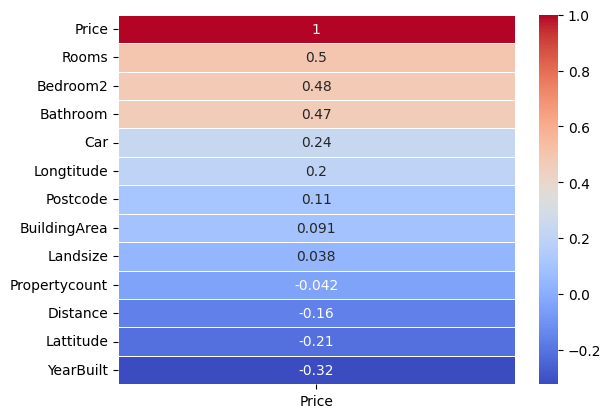

In [531]:
price_corr = df.corr(numeric_only=True)['Price'].sort_values(ascending=False)

sns.heatmap(price_corr.to_frame(), annot=True, cmap='coolwarm', linewidths=0.5)

Algo que refleja la data es que hay relación entre Precio y número de Rooms. La segunda variable es Bedroom2, osea que haya más de una habitación. <br />
Nos aporta más de lo mismo, así pudiendola eliminar del análisis por redundancia

In [532]:
corr_value = df[['Rooms', 'Bedroom2']].corr().iloc[0, 1]
print(f'Correlación entre Rooms y Bedroom2: {corr_value}')

Correlación entre Rooms y Bedroom2: 0.9441902739606949


## Elección de variables
Por ahora eligiremos Rooms, Bathroom, Landsize, BuildingArea, YearBuilt, Lattitude y Longitude. El proceso es iterativo y ciertamente puede haber errores que iremos descubriendo

In [533]:
house_features = ['Rooms', 'Bathroom', 'Landsize', 'BuildingArea', 'YearBuilt', 'Lattitude', 'Longtitude']

## Limpieza de nuestros datos

In [534]:
df_clean = df[[
    #'Suburb', 'Address',
     'Rooms', 
    #  'Type',
       'Price',
        #  'Method', 'SellerG',
    #    'Date', 'Distance', 'Postcode', 'Bedroom2', 
       'Bathroom',
        #  'Car',
       'Landsize', 'BuildingArea', 'YearBuilt', 
    #    'CouncilArea',
         'Lattitude', 'Longtitude',
        #    'Regionname', 'Propertycount'
]]

In [535]:
print(df_clean[house_features].isna().sum())
print(df_clean['Price'].isna().sum())

Rooms              0
Bathroom           0
Landsize           0
BuildingArea    6450
YearBuilt       5375
Lattitude          0
Longtitude         0
dtype: int64
0


Lo que nos interesa de esos datos faltantes es que nos podríamos estar perdiendo. Quizás son datos que sean díficiles de determinar, y no podemos hacer una imputación, o datos en los que sí podemos hacer una imputación y agregarle exactitud al modelo al tener más samples

In [536]:
rows_with_multiple_missing = df_clean[df_clean.isna().sum(axis=1) > 1]

print(f"Número de filas con más de 1 columna faltante : {len(rows_with_multiple_missing)}")

rows_with_multiple_missing

Número de filas con más de 1 columna faltante : 5103


,Rooms,Price,Bathroom,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude
0,2,1480000.0,1.0,202.0,NaN,NaN,-37.79960,144.99840
3,3,850000.0,2.0,94.0,NaN,NaN,-37.79690,144.99690
5,2,941000.0,1.0,181.0,NaN,NaN,-37.80410,144.99530
8,1,300000.0,1.0,0.0,NaN,NaN,-37.80080,144.99730
10,2,700000.0,2.0,0.0,NaN,NaN,-37.81100,145.00670
...,...,...,...,...,...,...,...,...
13566,4,1250000.0,2.0,986.0,NaN,NaN,-37.84679,145.20051
13567,5,1316000.0,3.0,696.0,NaN,NaN,-37.73501,145.08341
13569,4,1323000.0,2.0,551.0,NaN,NaN,-37.87608,145.22390
13570,3,970000.0,2.0,674.0,NaN,NaN,-37.88360,145.22805


In [537]:
df_clean = df_clean.dropna(thresh=df_clean.shape[1] - 1)

In [538]:
df_clean.isna().sum()

Rooms              0
Price              0
Bathroom           0
Landsize           0
BuildingArea    1347
YearBuilt        272
Lattitude          0
Longtitude         0
dtype: int64

Haremos imputación de las columnas, pero cuando no están ambas faltantes. Dado el tipo de valores faltantes, les imputaré la moda.

In [539]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='most_frequent')
df_clean[['YearBuilt', 'BuildingArea']] = imputer.fit_transform(df_clean[['YearBuilt', 'BuildingArea']])
df_clean.isna().sum()

Rooms           0
Price           0
Bathroom        0
Landsize        0
BuildingArea    0
YearBuilt       0
Lattitude       0
Longtitude      0
dtype: int64

En una iteración me di cuenta que Date se estaba tratando como objeto en vez de DateTime, y eso me generaba problemas

In [540]:
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df.dtypes

Suburb                   object
Address                  object
Rooms                     int64
Type                     object
Price                   float64
Method                   object
SellerG                  object
Date             datetime64[ns]
Distance                float64
Postcode                float64
Bedroom2                float64
Bathroom                float64
Car                     float64
Landsize                float64
BuildingArea            float64
YearBuilt               float64
CouncilArea              object
Lattitude               float64
Longtitude              float64
Regionname               object
Propertycount           float64
dtype: object

Ahora definiremos nuestras variables X, supuestamente independientes, y la variable afectada que queremos predecir a futuro: Price

In [541]:
X = df_clean[house_features]
y = df_clean['Price']

In [542]:
model_1 = DecisionTreeRegressor(random_state=1)
model_1.fit(X, y)

DecisionTreeRegressor(random_state=1)

In [543]:
prediction_model_1 = model_1.predict(X)
mean_absolute_error(y, prediction_model_1)

498.8793205143329

## Error de evalución dentro de la muestra
Pero qué pasa si hacemos la construcción del modelo y la evaluación con la misma muestra? Siempre nos va a dar bien, porque estará sesgado a su propia data. <br />
Quizás funciona bien para esta muestra, pero no es extrapolable a otras predicciones

## Train-test Split
Por eso se utiliza la separación de la muestra en una parte que entrena al modelo, y otra contra lo que se evalúa, llamada data de validación.

In [544]:
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=0)
model_2 = DecisionTreeRegressor()
model_2.fit(train_X, train_y)

model_2_prediction = model_2.predict(val_X)
print(mean_absolute_error(val_y, model_2_prediction))

262428.1816037736


Vemos que cuando no está sesgado el modelo a determinada data, el Error medio absoluto nos da mucho más.

## Sobreajuste o subajuste
Se utiliza más frecuentemente su versión en inglés. Overfitting y underfitting. <br />
El sobreajuste ocurre cuando un modelo aprende demasiado bien los detalles y el ruido del conjunto de entrenamiento, lo que reduce su capacidad de generalización a nuevos datos. <br />
El subajuste sucede cuando el modelo es demasiado simple y no logra capturar los patrones en los datos, resultando en un bajo desempeño tanto en entrenamiento como en prueba.

In [545]:

def get_mae(max_leaf_nodes, train_X, val_X, train_y, val_y):
    model = DecisionTreeRegressor(max_leaf_nodes=max_leaf_nodes, random_state=0)
    model.fit(train_X, train_y)
    preds_val = model.predict(val_X)
    mae = mean_absolute_error(val_y, preds_val)
    return(mae)


for max_leaf_nodes in [5, 50, 500, 5000]:
    my_mae = get_mae(max_leaf_nodes, train_X, val_X, train_y, val_y)
    print("Máxima cantidad de resultados finales: %d  \t\t Error Medio Absoluto:  %d" %(max_leaf_nodes, my_mae))

Máxima cantidad de resultados finales: 5  		 Error Medio Absoluto:  342118
Máxima cantidad de resultados finales: 50  		 Error Medio Absoluto:  272568
Máxima cantidad de resultados finales: 500  		 Error Medio Absoluto:  242993
Máxima cantidad de resultados finales: 5000  		 Error Medio Absoluto:  262437


Así cuando ya llega a 5000 resultados finales de los árboles de decisión, ya empieza a ajustar demasiado a la especificidad del modelo, y se sesga a esos valores. <br /> Pero hasta 500 ajusta bien a los datos

## Cómo se resuelve cuanto ajustar el modelo...
Esta tensión entre ajustar a los datos, pero poderlo generalizar está latente. Así el algoritmo de Random Tree Forest plantea una solución a este dilema. <br />
Tiene generalmente mejor exactitud que los árboles de decisión específicos, como se ve en el MEA.

In [546]:
def score_dataset(X_train, X_valid, y_train, y_valid):
    model = RandomForestRegressor(n_estimators=100, random_state=0)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)

forest_model = RandomForestRegressor(random_state=1)
forest_model.fit(train_X, train_y)
forest_model_prediction = forest_model.predict(val_X)
print(mean_absolute_error(val_y, forest_model_prediction))

183933.57224775385


## Agregando variables categóricas
Agregaremos las variables categóricas al modelo con One-Hot Encoder. El modelo performará mejor cuanta más información se agregue al modelo


In [547]:
boolean_category = (df.dtypes == 'object')
object_columns = list(boolean_category[boolean_category].index)
low_cardinality_cols = [col for col in object_columns if df[col].nunique() < 10 and df[col].dtype == 'object']
print(low_cardinality_cols)

['Type', 'Method', 'Regionname']


In [548]:
numerical_columns = list(df_clean.select_dtypes(include=[np.number]).columns)
numerical_columns.remove('Price')
print(numerical_columns)


['Rooms', 'Bathroom', 'Landsize', 'BuildingArea', 'YearBuilt', 'Lattitude', 'Longtitude']


In [549]:
df_clean[low_cardinality_cols] = df[low_cardinality_cols]
print(low_cardinality_cols)
df_clean

['Type', 'Method', 'Regionname']


,Rooms,Price,Bathroom,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Type,Method,Regionname
1,2,1035000.0,1.0,156.0,79.0,1900.0,-37.80790,144.99340,h,S,Northern Metropolitan
2,3,1465000.0,2.0,134.0,150.0,1900.0,-37.80930,144.99440,h,SP,Northern Metropolitan
4,4,1600000.0,1.0,120.0,142.0,2014.0,-37.80720,144.99410,h,VB,Northern Metropolitan
6,3,1876000.0,2.0,245.0,210.0,1910.0,-37.80240,144.99930,h,S,Northern Metropolitan
7,2,1636000.0,1.0,256.0,107.0,1890.0,-37.80600,144.99540,h,S,Northern Metropolitan
...,...,...,...,...,...,...,...,...,...,...,...
13575,4,1245000.0,2.0,652.0,120.0,1981.0,-37.90562,145.16761,h,S,South-Eastern Metropolitan
13576,3,1031000.0,2.0,333.0,133.0,1995.0,-37.85927,144.87904,h,SP,Western Metropolitan
13577,3,1170000.0,2.0,436.0,120.0,1997.0,-37.85274,144.88738,h,S,Western Metropolitan
13578,4,2500000.0,1.0,866.0,157.0,1920.0,-37.85908,144.89299,h,PI,Western Metropolitan


Limpiando datos para df con categorías incluidas

In [550]:
df_clean.isna().sum()   

Rooms           0
Price           0
Bathroom        0
Landsize        0
BuildingArea    0
YearBuilt       0
Lattitude       0
Longtitude      0
Type            0
Method          0
Regionname      0
dtype: int64

In [551]:
print(df_clean.isna().sum())
df_clean.shape

Rooms           0
Price           0
Bathroom        0
Landsize        0
BuildingArea    0
YearBuilt       0
Lattitude       0
Longtitude      0
Type            0
Method          0
Regionname      0
dtype: int64


(8477, 11)

In [552]:
X = df_clean.drop(columns=['Price'])
y = df_clean['Price']
train_X, val_X, train_y, val_y = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

## Pipeline
Vamos a transformar el preprocesamiento y el modelado de datos en un Pipeline, para hacerlo reutilizable ymás sencillo de entender. <br />
Además hace que sea más facil de llevar a producción, con menos bugs y más fáciles de rastrear.


In [553]:
numerical_transformer = SimpleImputer(strategy='median')

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('cat', categorical_transformer, low_cardinality_cols)
    ])

In [554]:
model = RandomForestRegressor(n_estimators=100, random_state=0)

In [555]:
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)], verbose=True)

my_pipeline.fit(train_X, train_y)

preds = my_pipeline.predict(val_X)

score = mean_absolute_error(val_y, preds)
print('MAE:', score)

[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   4.2s
MAE: 176325.54301212938


<!-- ## Agregando variables categóricas al análisis
Utilizamos One-Hot Encoder, para transformar las variables categóricas en arrays de números, y agregar información al modelo. Va a performar mejor cuanta más información tenga. -->